<a href="https://colab.research.google.com/github/nicole-yoong/Portfolio/blob/main/Geographical_Analysis_of_Haidilao_location.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Haidilao Closing 300 Stores by End of 2021

Hotpot chain Haidilao will be closing or suspending 300 stores by the end of this year, it announced on Friday, 5 November.

So what does it mean? Let us first look at how many restaurants are there in total in China by doing some simple web scrapping. Go to Haidilao website and the branch locator. By inspecting the elements we can pull out all the stores information. 

# Scrapping data from Haidilao website

In [ ]:
import requests
import pandas as pd


url = 'https://www.haidilao.com/eportal/store/listObjByPosition?country=CN&language=zh'
headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/83.0.4103.97 Safari/537.36",
    "accept": "application/json, text/plain, */*"
    }
r = requests.get(url, headers=headers)
data = r.json()
df = pd.DataFrame(data['value'])
df.to_excel('haidilao.xlsx',index=False)

In [ ]:
df.head()

,storeId,countryId,storeName,storeAddress,storeTelephone,openStatus,openTime,longitude,latitude,isDisplay,distance
0,020189,CN,王府井丹耀店,北京市东城区王府井大街176号丹耀大厦三层,"010-85895994,010-85110994",1,早10:00--次日凌晨3:00,116.418280,39.918790,1,1.28
1,020161,CN,王府井银泰in88店,北京市东城区王府井大街88号银泰in88三层311号,"010-59785688,010-59785689",1,早9:00~次日凌晨7:00,116.417990,39.922474,1,1.46
2,020134,CN,新世界百货店,北京市东城区崇文门外大街新世界百货5层,010-67080561,1,早10:30~次日凌晨7:00,116.424126,39.904580,1,2.03
3,020106,CN,西单店,北京市西城区西单北大街109号西单婚庆大楼7层(西单商场对面),"010-66174063,010-66174043",1,早上10:00~次日凌晨07:00,116.379620,39.920303,1,2.20
4,0201113,CN,悠唐购物中心店,北京市朝阳区三丰北里2号楼悠唐购物中心5层,"010-85270848,010-85270849",1,早9:00-次日7：00,116.440270,39.921665,1,3.17


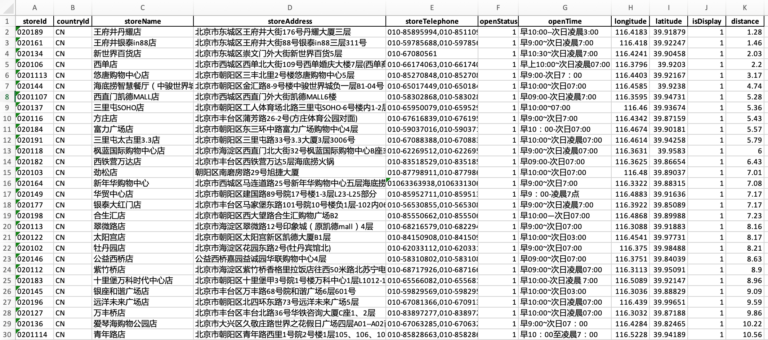

We can see that there are currently 1323 stores. By closing down 300 stores, it means 22.7% of the stores will be closed down. That’s a lot! Let’s now explore into which city has the highest number of Haidilao restaurants using Gaode map. 

# Geographical analysis

In [ ]:
pip install geopandas

In [ ]:
import geopandas as gpd
import geopy
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import matplotlib.pyplot as plt
import tqdm
from tqdm._tqdm_notebook import tqdm_notebook


df['geom'] = df['latitude'].map(str) + ',' + df['longitude'].map(str)
df['geom'][0]

'39.91879,116.41828'

In [ ]:
locator = Nominatim(user_agent='myGeocoder', timeout=10)
rgeocode = RateLimiter(locator.reverse, min_delay_seconds=0.001)

In [ ]:
tqdm_notebook.pandas()
df['address'] = df['geom'].progress_apply(rgeocode)
df.head()

df.to_excel('haidilao_address.xlsx',index=False)

In [ ]:
pip install googletrans==4.0.0-rc1

  Created wheel for googletrans: filename=googletrans-4.0.0rc1-py3-none-any.whl size=17415 sha256=91da1de164d02ac2db2fa158af46362d3b4ce28db3c150f606d5aacafed4beee
  Stored in directory: /root/.cache/pip/wheels/43/34/00/4fe71786ea6d12314b29037620c36d857e5d104ac2748bf82a
Successfully built googletrans
  Attempting uninstall: googletrans
    Found existing installation: googletrans 3.0.0
    Uninstalling googletrans-3.0.0:
      Successfully uninstalled googletrans-3.0.0


In [ ]:
cities = []
provinces = []

for i , location in enumerate(df[['longitude','latitude']].values):
    location = str(location[0])+','+str(location[1])
    url = 'https://restapi.amap.com/v3/geocode/regeo?'  ## convert the format of longitude and latitude based on gaode map 
    params = {
        'location':location,
        'key':'4e3f878e4f74ad3b522d10830e54cfa2',
        'extensions':'base',
        'batch':'false',
        'roadlevel':0,
        }
    
    r = requests.get(url, params=params)
    data = r.json()['regeocode']
    city = data['addressComponent']['city']
    province = data['addressComponent']['province']

    if len(city)==0:
        city = province 
    cities.append(city)
    provinces.append(province)

    print(f'\r{i+1}',end='')

df['city'] = cities

print (df['city'])

13220       北京市
1       北京市
2       北京市
3       北京市
4       北京市
       ... 
1317    儋州市
1318    普洱市
1319    三亚市
1320    三亚市
1321    三亚市
Name: city, Length: 1322, dtype: object


In [ ]:
df.groupby('city')['storeId'].nunique().sort_values(ascending=False).head(10)


city
北京市    73
上海市    70
深圳市    51
西安市    51
广州市    46
武汉市    41
杭州市    40
郑州市    38
南京市    31
天津市    30
Name: storeId, dtype: int64

In [ ]:
print (df)

      storeId countryId   storeName  ... isDisplay distance  city
0       20189        CN      王府井丹耀店  ...         1     1.28   北京市
1       20161        CN  王府井银泰in88店  ...         1     1.46   北京市
2       20134        CN      新世界百货店  ...         1     2.03   北京市
3       20106        CN         西单店  ...         1     2.20   北京市
4      201113        CN     悠唐购物中心店  ...         1     3.17   北京市
...       ...       ...         ...  ...       ...      ...   ...
1317   111605        CN     儋州夏日广场店  ...         1  2360.47   儋州市
1318   111407        CN       普洱中心店  ...         1  2396.73   普洱市
1319   111602        CN      三亚亚龙湾店  ...         1  2498.69   三亚市
1320   111603        CN        青春颂店  ...         1  2498.74   三亚市
1321   111601        CN       时代海岸店  ...         1  2502.12   三亚市

[1322 rows x 12 columns]


# Visualization 

To visualise the numbers,   let’s use Folium, a Python library used for visualizing geospatial data.

## Folium

In [ ]:
import folium
from IPython.display import display

# creating an empty map
map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=10, control_scale=True)


# adding points to the map
for index, location_info in df.iterrows():
    folium.Marker([location_info["latitude"], 
                   location_info["longitude"]], 
                  icon=folium.Icon(color="red", icon="info-sign"),
                  popup=location_info["storeName"]).add_to(map)

display (map)

Zooming in, we can observe that Shanghai area is highly concentrated.